In [10]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("swoyam2609/fresh-and-stale-classification")

print("Path to dataset files:", path)

Path to dataset files: /home/sugeng/.cache/kagglehub/datasets/swoyam2609/fresh-and-stale-classification/versions/1


In [11]:
import os
import shutil
import numpy as np

In [12]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

# Define the ImageDataGenerator
train_ds = image_dataset_from_directory(
    path+'/dataset/Train',
    validation_split=0.2,
    label_mode='categorical',
    subset="training",
    color_mode='rgb',
    seed=1337,
    image_size=(224, 224),
    shuffle=True,
    batch_size=32,
)
val_ds = image_dataset_from_directory(
    path+'/dataset/Train',
    validation_split=0.2,
    label_mode='categorical',
    subset="validation",
    color_mode='rgb',
    seed=1337,
    shuffle=True,
    image_size=(224, 224),
    batch_size=32,
)

Found 23832 files belonging to 18 classes.
Using 19066 files for training.
Found 23832 files belonging to 18 classes.
Using 4766 files for validation.


In [13]:
'''
Data preprocessing 
- Rescale the pixel values to the [0, 1] range
- Standardize the data
- Enhancing  contrast and brightness
- Higher saturation
- Data augmentation
'''

from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Rescaling
from tensorflow.keras.layers import Resizing
from tensorflow.keras.layers import RandomContrast
from tensorflow.keras.layers import RandomBrightness
# from tensorflow.image import random_saturation
from tensorflow.keras.layers import RandomRotation
from tensorflow.keras.layers import RandomZoom
from tensorflow.keras.layers import RandomFlip

data_augmentation = Sequential([
    RandomContrast(0.2),
    RandomBrightness(0.2),
    RandomRotation(0.2),
    RandomZoom(0.2),
    RandomFlip('horizontal'),
])



In [14]:
label = ['freshapples', 'freshbanana', 'freshbittergroud', 'freshcapsicum', 'freshcucumber', 'freshokra', 'freshoranges', 'freshpotato', 'freshtomato', 'rottenapples', 'rottenbanana', 'rottenbittergroud', 'rottencapsicum', 'rottencucumber', 'rottenokra', 'rottenoranges', 'rottenpotato', 'rottentomato']

2024-11-07 14:25:15.614153: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


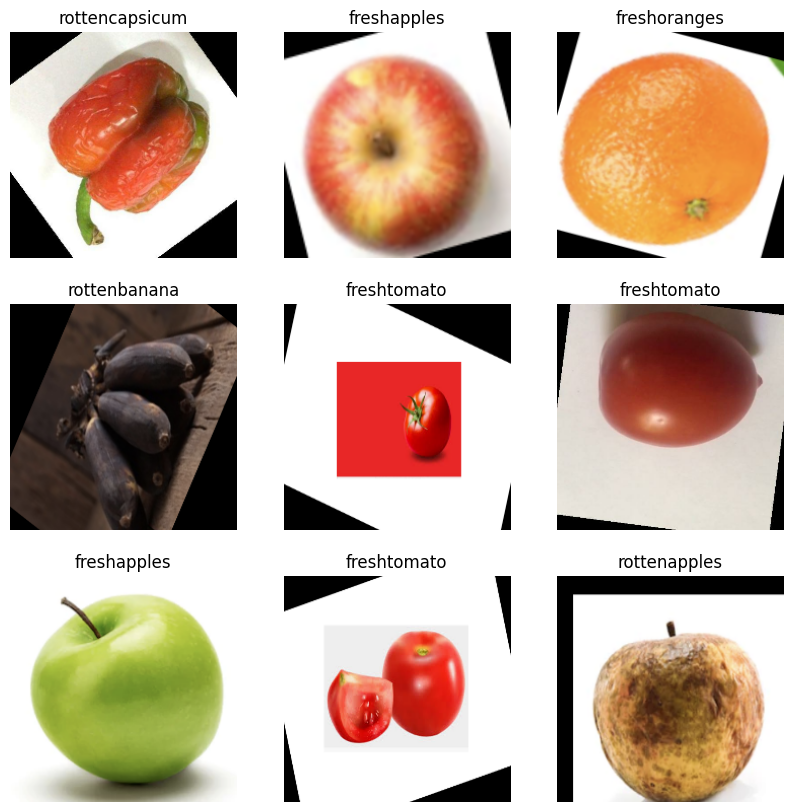

In [15]:
# Plot the first 9 images
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(label[np.argmax(labels[i])])
        plt.axis("off")
        
plt.show()

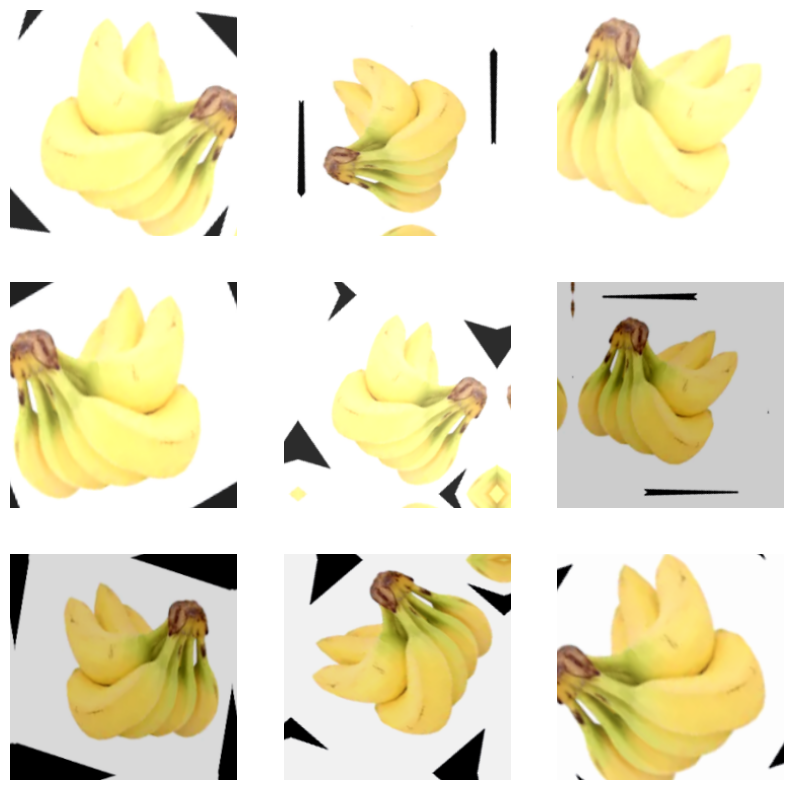

In [16]:
# Plot augmented images
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")
plt.show()

In [17]:
# import pretrained model (resnet50)
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV3Large, EfficientNetV2L, ResNet50V2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
# Add data augmentation layer
model = Sequential([
    data_augmentation,
    Rescaling(1./255),
    base_model,
    GlobalAveragePooling2D(),
    Dense(1024, activation='relu'),
    Dense(18, activation='softmax')
])

In [18]:
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train model with early stopping
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', 'AUC', 'Precision', 'Recall'])

history = model.fit(train_ds, validation_data=val_ds, epochs=30, callbacks=[early_stop])


Epoch 1/30


E0000 00:00:1730964329.186054   32697 cuda_dnn.cc:522] Loaded runtime CuDNN library: 9.1.0 but source was compiled with: 9.3.0.  CuDNN library needs to have matching major version and equal or higher minor version. If using a binary install, upgrade your CuDNN library.  If building from sources, make sure the library loaded at runtime is compatible with the version specified during compile configuration.
2024-11-07 14:25:29.186409: W tensorflow/core/framework/op_kernel.cc:1841] OP_REQUIRES failed at conv_ops_impl.h:1204 : INVALID_ARGUMENT: No DNN in stream executor.


InvalidArgumentError: Graph execution error:

Detected at node sequential_3_1/resnet50v2_1/conv1_conv_1/convolution defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/home/sugeng/miniconda3/lib/python3.12/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/home/sugeng/miniconda3/lib/python3.12/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/sugeng/miniconda3/lib/python3.12/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/sugeng/miniconda3/lib/python3.12/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/home/sugeng/miniconda3/lib/python3.12/asyncio/base_events.py", line 639, in run_forever

  File "/home/sugeng/miniconda3/lib/python3.12/asyncio/base_events.py", line 1985, in _run_once

  File "/home/sugeng/miniconda3/lib/python3.12/asyncio/events.py", line 88, in _run

  File "/home/sugeng/miniconda3/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue

  File "/home/sugeng/miniconda3/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 534, in process_one

  File "/home/sugeng/miniconda3/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/home/sugeng/miniconda3/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 362, in execute_request

  File "/home/sugeng/miniconda3/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 778, in execute_request

  File "/home/sugeng/miniconda3/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 449, in do_execute

  File "/home/sugeng/miniconda3/lib/python3.12/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/home/sugeng/miniconda3/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3075, in run_cell

  File "/home/sugeng/miniconda3/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3130, in _run_cell

  File "/home/sugeng/miniconda3/lib/python3.12/site-packages/IPython/core/async_helpers.py", line 128, in _pseudo_sync_runner

  File "/home/sugeng/miniconda3/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3334, in run_cell_async

  File "/home/sugeng/miniconda3/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3517, in run_ast_nodes

  File "/home/sugeng/miniconda3/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code

  File "/tmp/ipykernel_32218/217174470.py", line 9, in <module>

  File "/home/sugeng/miniconda3/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/sugeng/miniconda3/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 320, in fit

  File "/home/sugeng/miniconda3/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 121, in one_step_on_iterator

  File "/home/sugeng/miniconda3/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 108, in one_step_on_data

  File "/home/sugeng/miniconda3/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 51, in train_step

  File "/home/sugeng/miniconda3/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/sugeng/miniconda3/lib/python3.12/site-packages/keras/src/layers/layer.py", line 899, in __call__

  File "/home/sugeng/miniconda3/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/sugeng/miniconda3/lib/python3.12/site-packages/keras/src/ops/operation.py", line 46, in __call__

  File "/home/sugeng/miniconda3/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/home/sugeng/miniconda3/lib/python3.12/site-packages/keras/src/models/sequential.py", line 213, in call

  File "/home/sugeng/miniconda3/lib/python3.12/site-packages/keras/src/models/functional.py", line 182, in call

  File "/home/sugeng/miniconda3/lib/python3.12/site-packages/keras/src/ops/function.py", line 171, in _run_through_graph

  File "/home/sugeng/miniconda3/lib/python3.12/site-packages/keras/src/models/functional.py", line 584, in call

  File "/home/sugeng/miniconda3/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/sugeng/miniconda3/lib/python3.12/site-packages/keras/src/layers/layer.py", line 899, in __call__

  File "/home/sugeng/miniconda3/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/sugeng/miniconda3/lib/python3.12/site-packages/keras/src/ops/operation.py", line 46, in __call__

  File "/home/sugeng/miniconda3/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/home/sugeng/miniconda3/lib/python3.12/site-packages/keras/src/models/functional.py", line 182, in call

  File "/home/sugeng/miniconda3/lib/python3.12/site-packages/keras/src/ops/function.py", line 171, in _run_through_graph

  File "/home/sugeng/miniconda3/lib/python3.12/site-packages/keras/src/models/functional.py", line 584, in call

  File "/home/sugeng/miniconda3/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/sugeng/miniconda3/lib/python3.12/site-packages/keras/src/layers/layer.py", line 899, in __call__

  File "/home/sugeng/miniconda3/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/sugeng/miniconda3/lib/python3.12/site-packages/keras/src/ops/operation.py", line 46, in __call__

  File "/home/sugeng/miniconda3/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/home/sugeng/miniconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py", line 243, in call

  File "/home/sugeng/miniconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py", line 233, in convolution_op

  File "/home/sugeng/miniconda3/lib/python3.12/site-packages/keras/src/ops/nn.py", line 901, in conv

  File "/home/sugeng/miniconda3/lib/python3.12/site-packages/keras/src/backend/tensorflow/nn.py", line 258, in conv

  File "/home/sugeng/miniconda3/lib/python3.12/site-packages/keras/src/backend/tensorflow/nn.py", line 231, in _conv

No DNN in stream executor.
	 [[{{node sequential_3_1/resnet50v2_1/conv1_conv_1/convolution}}]] [Op:__inference_one_step_on_iterator_84674]

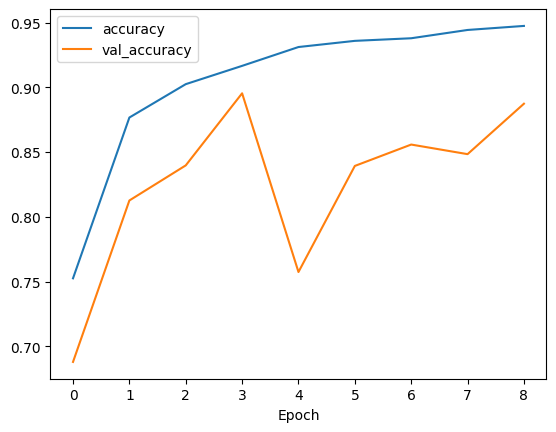

In [ ]:
# Plot the training history
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.legend()

In [ ]:
# save model 
import tensorflow as tf
model_without_augmentation = Sequential(model.layers[1:])
model_without_augmentation.save('model.keras')

/home/sugeng/miniconda3/lib/python3.12/site-packages/keras/src/saving/saving_api.py:107: UserWarning: You are saving a model that has not yet been built. It might not contain any weights yet. Consider building the model first by calling it on some data.
  return saving_lib.save_model(model, filepath)


Found 6738 files belonging to 14 classes.
211/211 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step


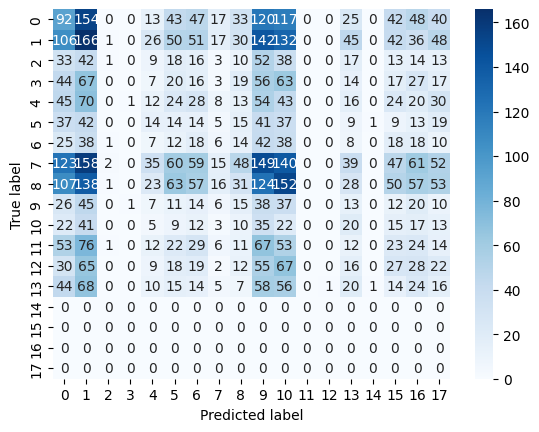

In [ ]:
# plot confusion matrix
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn
import pandas

test_ds = image_dataset_from_directory(
    path+'/dataset/Test',
    label_mode='categorical',
    color_mode='rgb',
    seed=1337,
    image_size=(224, 224),
    batch_size=32,
)

# Get the true classes
y_true = np.concatenate([y for x, y in test_ds], axis=0)
y_true = np.argmax(y_true, axis=1)  # Convert y_true to binary format
# Get the predicted classes
y_pred = model.predict(test_ds)
y_pred = np.argmax(y_pred, axis=1)

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
seaborn.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()



In [ ]:
# Evaluate the model
model.evaluate(test_ds)

2024-11-05 16:36:49.848254: W tensorflow/core/framework/op_kernel.cc:1829] INVALID_ARGUMENT: required broadcastable shapes
2024-11-05 16:36:49.848324: W tensorflow/core/framework/op_kernel.cc:1829] INVALID_ARGUMENT: required broadcastable shapes
2024-11-05 16:36:49.848367: W tensorflow/core/framework/op_kernel.cc:1829] INVALID_ARGUMENT: required broadcastable shapes
2024-11-05 16:36:49.848390: W tensorflow/core/framework/op_kernel.cc:1841] OP_REQUIRES failed at segment_reduction_ops_impl.h:505 : INVALID_ARGUMENT: data.shape = [448] does not start with segment_ids.shape = [576]
2024-11-05 16:36:49.848405: W tensorflow/core/framework/op_kernel.cc:1841] OP_REQUIRES failed at segment_reduction_ops_impl.h:505 : INVALID_ARGUMENT: data.shape = [448] does not start with segment_ids.shape = [576]


InvalidArgumentError: Graph execution error:

Detected at node compile_loss/categorical_crossentropy/softmax_cross_entropy_with_logits defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/home/sugeng/miniconda3/lib/python3.12/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/home/sugeng/miniconda3/lib/python3.12/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/sugeng/miniconda3/lib/python3.12/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/sugeng/miniconda3/lib/python3.12/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/home/sugeng/miniconda3/lib/python3.12/asyncio/base_events.py", line 639, in run_forever

  File "/home/sugeng/miniconda3/lib/python3.12/asyncio/base_events.py", line 1985, in _run_once

  File "/home/sugeng/miniconda3/lib/python3.12/asyncio/events.py", line 88, in _run

  File "/home/sugeng/miniconda3/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue

  File "/home/sugeng/miniconda3/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 534, in process_one

  File "/home/sugeng/miniconda3/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/home/sugeng/miniconda3/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 362, in execute_request

  File "/home/sugeng/miniconda3/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 778, in execute_request

  File "/home/sugeng/miniconda3/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 449, in do_execute

  File "/home/sugeng/miniconda3/lib/python3.12/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/home/sugeng/miniconda3/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3075, in run_cell

  File "/home/sugeng/miniconda3/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3130, in _run_cell

  File "/home/sugeng/miniconda3/lib/python3.12/site-packages/IPython/core/async_helpers.py", line 128, in _pseudo_sync_runner

  File "/home/sugeng/miniconda3/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3334, in run_cell_async

  File "/home/sugeng/miniconda3/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3517, in run_ast_nodes

  File "/home/sugeng/miniconda3/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code

  File "/tmp/ipykernel_152606/4097528427.py", line 2, in <module>

  File "/home/sugeng/miniconda3/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/sugeng/miniconda3/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 432, in evaluate

  File "/home/sugeng/miniconda3/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 165, in one_step_on_iterator

  File "/home/sugeng/miniconda3/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 154, in one_step_on_data

  File "/home/sugeng/miniconda3/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 85, in test_step

  File "/home/sugeng/miniconda3/lib/python3.12/site-packages/keras/src/trainers/trainer.py", line 398, in _compute_loss

  File "/home/sugeng/miniconda3/lib/python3.12/site-packages/keras/src/trainers/trainer.py", line 366, in compute_loss

  File "/home/sugeng/miniconda3/lib/python3.12/site-packages/keras/src/trainers/compile_utils.py", line 618, in __call__

  File "/home/sugeng/miniconda3/lib/python3.12/site-packages/keras/src/trainers/compile_utils.py", line 659, in call

  File "/home/sugeng/miniconda3/lib/python3.12/site-packages/keras/src/losses/loss.py", line 60, in __call__

  File "/home/sugeng/miniconda3/lib/python3.12/site-packages/keras/src/losses/losses.py", line 27, in call

  File "/home/sugeng/miniconda3/lib/python3.12/site-packages/keras/src/losses/losses.py", line 1721, in categorical_crossentropy

  File "/home/sugeng/miniconda3/lib/python3.12/site-packages/keras/src/ops/nn.py", line 1474, in categorical_crossentropy

  File "/home/sugeng/miniconda3/lib/python3.12/site-packages/keras/src/backend/tensorflow/nn.py", line 597, in categorical_crossentropy

logits and labels must be broadcastable: logits_size=[32,18] labels_size=[32,14]
	 [[{{node compile_loss/categorical_crossentropy/softmax_cross_entropy_with_logits}}]] [Op:__inference_one_step_on_iterator_1087237]

In [ ]:
# pred single image
import numpy as np
from tensorflow.keras.preprocessing import image

img_path = '/home/sugeng/Downloads/rotten.jpeg'
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)

predictions = model.predict(img_array)
for i, lbl in enumerate(label):
    print(f'{lbl}: {predictions[0][i]:.4f}')


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 670ms/step
freshapples: 0.0001
freshbanana: 0.0639
freshbittergroud: 0.0000
freshcapsicum: 0.0000
freshcucumber: 0.0000
freshokra: 0.0000
freshoranges: 0.0000
freshpotato: 0.0008
freshtomato: 0.0000
rottenapples: 0.7065
rottenbanana: 0.1702
rottenbittergroud: 0.0003
rottencapsicum: 0.0000
rottencucumber: 0.0072
rottenokra: 0.0001
rottenoranges: 0.0045
rottenpotato: 0.0448
rottentomato: 0.0015


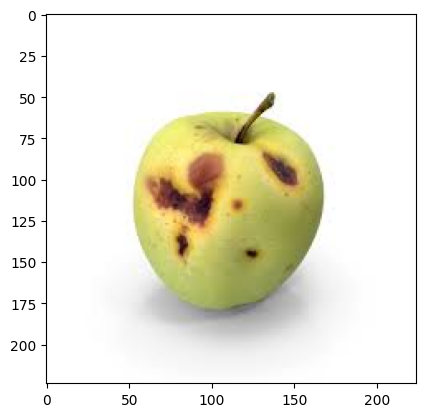

In [ ]:
# plot the image
plt.imshow(img)
plt.show()


In [ ]:
import tensorflow_hub as hub
# Apply image detector on a single image.
detector = hub.load("https://www.kaggle.com/models/tensorflow/efficientdet/TensorFlow2/d0/1")
detector_output = detector(img_array)


In [ ]:
# Place detected bounding boxes on the image
from PIL import Image
from PIL import ImageDraw

def draw_bounding_boxes_on_image(image, boxes, classes, scores, max_boxes=1, min_score=0.1):
    image_width, image_height = image.size
    draw = ImageDraw.Draw(image)
    for i in range(min(boxes.shape[0], max_boxes)):
        if scores[i] >= min_score:
            ymin, xmin, ymax, xmax = tuple(boxes[i])
            (left, right, top, bottom) = (xmin * image_width, xmax * image_width,
                                          ymin * image_height, ymax * image_height)
            draw.line([(left, top), (left, bottom), (right, bottom),
                       (right, top), (left, top)], width=1, fill='red')
            text = "{}: {:.2f}".format(classes[i], scores[i])
            draw.text((left, top), text, fill='red')

    return image

# Draw the bounding boxes on the image

image_with_boxes = draw_bounding_boxes_on_image(Image.fromarray(img_array[0].astype(np.uint8)),
                                                detector_output['detection_boxes'][0].numpy(),
                                                detector_output['detection_classes'][0].numpy().astype(int),
                                                detector_output['detection_scores'][0].numpy())

# crop images
from PIL import Image

def crop_image(image, boxes):
    image_width, image_height = image.size
    cropped_images = []
    for i in range(boxes.shape[0]):
        ymin, xmin, ymax, xmax = tuple(boxes[i])
        (left, right, top, bottom) = (xmin * image_width, xmax * image_width,
                                      ymin * image_height, ymax * image_height)
        cropped_images.append(image.crop((left, top, right, bottom)))

    return cropped_images[0]

# Crop the image
cropped_image = crop_image(Image.fromarray(img_array[0].astype(np.uint8)),
                           detector_output['detection_boxes'][0].numpy())

# Display the cropped image
plt.imshow(cropped_image)

In [ ]:
# Display the image with bounding boxes
plt.imshow(image_with_boxes)

In [ ]:
# Predict cropped image
cropped_image = cropped_image.resize((224, 224))
cropped_image = image.img_to_array(cropped_image)
cropped_image = np.expand_dims(cropped_image, axis=0)

predictions = model.predict(cropped_image)
for i, lbl in enumerate(label):
    print(f'{lbl}: {predictions[0][i]:.4f}')